# Importing Libs

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', None)
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
import warnings
warnings.filterwarnings('ignore')

# Importing BizDomains

In [2]:
BizDomains = pd.read_csv('BizDomainsId.csv').drop('Unnamed: 0',axis=1)

# Importing KMedoids=2 Dataset

In [3]:
df_medoid = pd.read_csv(r"K-Medoids_k=2_Numerical.csv").drop('Unnamed: 0',axis=1)
df_medoid.head()

,no_warning_sign,BizActive?,AddedUsers/BoughtUser,ActiveUsers/AddedUsers,#Activities,ActivitiesWoutDeal/#Activities,AvgDelayTimeActivity,#Activities/#Deals,%NoAcquitance,TransformationSpeed,TransformationRate,%NoReasonFailure,#OngoingDeals/#Total(Correct)Deals,BizIsExpired?
0,0.000000,0,0.642724,0.181397,1,0.866667,4,1.068966,0.310345,2,2,3,0.500000,1
1,0.238875,1,0.398507,0.274307,3,0.662252,3,0.688889,0.917526,2,2,1,0.627451,0
2,0.822599,0,1.000000,0.949580,1,0.000000,4,1.444444,0.000000,1,3,1,0.846154,0
3,0.000000,0,1.000000,0.211382,1,1.000000,3,0.000000,0.602430,2,2,2,0.506440,1
4,0.082940,1,1.000000,0.804726,4,0.773725,2,3.579350,0.182724,2,1,2,0.013858,0


# Train/Test Split

In [4]:
from sklearn.model_selection import train_test_split
X = df_medoid[[x for x in df_medoid.columns if x!='BizIsExpired?']]
y = df_medoid['BizIsExpired?']

X_train , X_test , y_train , y_test = train_test_split(X,y , test_size=0.3 , random_state=1)

## Metric Calculator Function

In [5]:
def metric_calculator(y_test , y_test_pred):
    f1_res = f1_score(y_test,y_test_pred)
    accuracy_res = accuracy_score(y_test, y_test_pred)
    roc_res = roc_auc_score(y_test, y_test_pred)
    prec = precision_score(y_test , y_test_pred)
    rec = recall_score(y_test , y_test_pred)
    return [f1_res , accuracy_res , roc_res , prec , rec]

## Dummy Classifiers

### most_frequent

In [6]:
dummy_clf = DummyClassifier(strategy = 'most_frequent' , random_state=1)
dummy_clf.fit(X_train , y_train)
df_metric = pd.DataFrame(index = ['F1 Score' , 'accuracy' , 'ROC AUC' , 'Precision','Recall'])
df_metric['most_frequent'] = metric_calculator(y_test ,dummy_clf.predict(X_test) )
df_metric

,most_frequent
F1 Score,0.000000
accuracy,0.650877
ROC AUC,0.500000
Precision,0.000000
Recall,0.000000


### stratified

In [7]:
dummy_clf = DummyClassifier(strategy = 'stratified' , random_state=1 )
dummy_clf.fit(X_train , y_train)

df_metric['stratified'] = metric_calculator(y_test ,dummy_clf.predict(X_test) )

### uniform

In [8]:
dummy_clf = DummyClassifier(strategy = 'uniform' , random_state=1 )
dummy_clf.fit(X_train , y_train)

df_metric['uniform'] = metric_calculator(y_test ,dummy_clf.predict(X_test) )

In [9]:
df_metric

,most_frequent,stratified,uniform
F1 Score,0.000000,0.361949,0.403361
accuracy,0.650877,0.517544,0.501754
ROC AUC,0.500000,0.488433,0.497271
Precision,0.000000,0.336207,0.346570
Recall,0.000000,0.391960,0.482412


## Logistic Regression (Good)

### GridSearch

In [10]:
logreg = LogisticRegression(penalty = 'l2',random_state=0)
grid_C = {'C': [0.01, 0.1 , 0.5 , 1,3,5,6,7,8,9,10,20,30,50]}
scorer = {"AUC": "roc_auc", "F1": make_scorer(f1_score) , 
          "Accuracy": 'accuracy'}
grid_LogReg=GridSearchCV(logreg ,param_grid=grid_C, n_jobs=-1 , cv=10 , verbose = 5,
                         scoring=scorer , refit='F1')
grid_LogReg.fit(X_train , y_train )
print('best paramters= {}\nbest score= {}'.format(grid_LogReg.best_params_ , grid_LogReg.best_score_) )

Fitting 10 folds for each of 14 candidates, totalling 140 fits
best paramters= {'C': 0.5}
best score= 0.9425309208117515


### Metrics

In [11]:
df_metric['Value_LogReg'] = metric_calculator(y_test ,grid_LogReg.predict(X_test) )

In [12]:
df_metric

,most_frequent,stratified,uniform,Value_LogReg
F1 Score,0.000000,0.361949,0.403361,0.934010
accuracy,0.650877,0.517544,0.501754,0.954386
ROC AUC,0.500000,0.488433,0.497271,0.947487
Precision,0.000000,0.336207,0.346570,0.943590
Recall,0.000000,0.391960,0.482412,0.924623


### Health Score for All

In [13]:
logreg = LogisticRegression(penalty = 'l2',random_state=0 , C=0.5)
y_dec_lr = (logreg.fit(X, y).decision_function(X)).reshape(-1,1)
y_dec_lr = MinMaxScaler(feature_range=(0, 10)).fit_transform(y_dec_lr)
df_medoid['Health_Score'] = 10 - y_dec_lr
df_medoid['BizDomainsId'] = BizDomains['BizDomainId']
df_medoid.head()

,no_warning_sign,BizActive?,AddedUsers/BoughtUser,ActiveUsers/AddedUsers,#Activities,ActivitiesWoutDeal/#Activities,AvgDelayTimeActivity,#Activities/#Deals,%NoAcquitance,TransformationSpeed,TransformationRate,%NoReasonFailure,#OngoingDeals/#Total(Correct)Deals,BizIsExpired?,Health_Score,BizDomainsId
0,0.000000,0,0.642724,0.181397,1,0.866667,4,1.068966,0.310345,2,2,3,0.500000,1,1.096923,0006df37-709c-4121-be9e-5210adc6a044
1,0.238875,1,0.398507,0.274307,3,0.662252,3,0.688889,0.917526,2,2,1,0.627451,0,6.431584,002d52c3-6c10-41a5-a4b2-91422a1ab307
2,0.822599,0,1.000000,0.949580,1,0.000000,4,1.444444,0.000000,1,3,1,0.846154,0,5.089191,00428596-e168-49ce-8428-7949cd2215ea
3,0.000000,0,1.000000,0.211382,1,1.000000,3,0.000000,0.602430,2,2,2,0.506440,1,1.375327,0049986f-b17d-44ef-992f-88d478dd21b8
4,0.082940,1,1.000000,0.804726,4,0.773725,2,3.579350,0.182724,2,1,2,0.013858,0,6.213732,004c3ec1-da71-494d-9adb-8a4e660f9257


### Successful Customers Checking

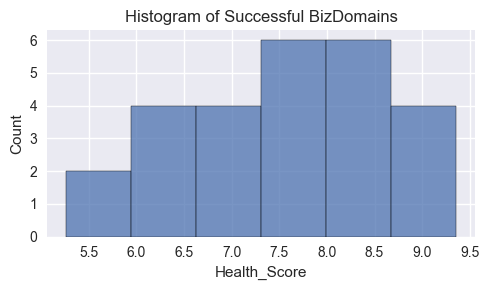

In [14]:
successful  = pd.read_csv(r"SuccesfulCustomers.csv")
successful = successful['BizDomainId'].str.lower()
plt.figure(figsize=(5,3))
plt.style.use('seaborn')
sns.histplot(df_medoid.loc[df_medoid['BizDomainsId'].isin(successful),'Health_Score'])
plt.title('Histogram of Successful BizDomains')
plt.tight_layout()
# plt.savefig('25. LogReg Successful Biz.jpg',dpi=200)
plt.show()

### Export

In [15]:
# df_medoid.to_csv('1. medoid k=2 LogReg Report.csv')

## KNN

### GridSearch

In [16]:
KNN = KNeighborsClassifier()
n_neighbor = {'n_neighbors': np.arange(2,10)}
scorer = {"AUC": "roc_auc", "F1": make_scorer(f1_score) , 
          "Accuracy": 'accuracy'}
grid_KNN=GridSearchCV(KNN ,param_grid=n_neighbor, n_jobs=-1 , cv=10 , verbose = 5,
                         scoring=scorer , refit='F1')
grid_KNN.fit(X_train , y_train )
print('best paramters= {}\nbest score= {}'.format(grid_KNN.best_params_ , grid_KNN.best_score_) )

Fitting 10 folds for each of 8 candidates, totalling 80 fits
best paramters= {'n_neighbors': 7}
best score= 0.8878904447736848


### Metrics

In [17]:
df_metric['Value_KNN'] = metric_calculator(y_test , grid_KNN.predict(X_test))
df_metric

,most_frequent,stratified,uniform,Value_LogReg,Value_KNN
F1 Score,0.000000,0.361949,0.403361,0.934010,0.888889
accuracy,0.650877,0.517544,0.501754,0.954386,0.924561
ROC AUC,0.500000,0.488433,0.497271,0.947487,0.910597
Precision,0.000000,0.336207,0.346570,0.943590,0.914894
Recall,0.000000,0.391960,0.482412,0.924623,0.864322


### Health Score for All

In [18]:
KNN = KNeighborsClassifier(n_neighbors=7)
y_dec_lr = (KNN.fit(X, y).predict_proba(X)[: , 1]).reshape(-1,1)
y_dec_lr = MinMaxScaler(feature_range=(0, 10)).fit_transform(y_dec_lr)
df_medoid['Health_Score'] = 10 - y_dec_lr
df_medoid['BizDomainsId'] = BizDomains['BizDomainId']
# df_medoid.head()

### Successful Customers Checking

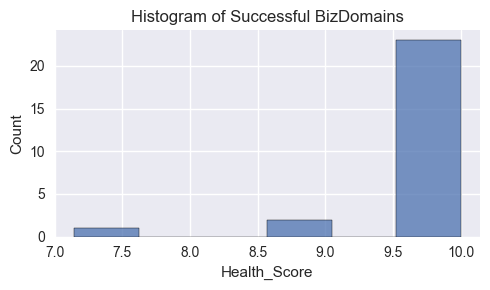

In [19]:
successful  = pd.read_csv(r"D:\uni\ترم 6\کارآموزی\Data\SuccesfulCustomers.csv")
successful = successful['BizDomainId'].str.lower()
plt.figure(figsize=(5,3))
plt.style.use('seaborn')
sns.histplot(df_medoid.loc[df_medoid['BizDomainsId'].isin(successful),'Health_Score'])
plt.title('Histogram of Successful BizDomains')
plt.tight_layout()
# plt.savefig('26. KNN Successful Biz.jpg',dpi=200)
plt.show()

In [20]:
KNN = KNeighborsClassifier(n_neighbors = 7)
y_dec_knn = (KNN.fit(X, y).predict_proba(X)[:,1]).reshape(-1,1)
y_dec_knn = MinMaxScaler(feature_range=(0, 10)).fit_transform(y_dec_knn)
df_medoid['Health_Score'] = 10 - y_dec_knn
df_medoid.head()

,no_warning_sign,BizActive?,AddedUsers/BoughtUser,ActiveUsers/AddedUsers,#Activities,ActivitiesWoutDeal/#Activities,AvgDelayTimeActivity,#Activities/#Deals,%NoAcquitance,TransformationSpeed,TransformationRate,%NoReasonFailure,#OngoingDeals/#Total(Correct)Deals,BizIsExpired?,Health_Score,BizDomainsId
0,0.000000,0,0.642724,0.181397,1,0.866667,4,1.068966,0.310345,2,2,3,0.500000,1,0.000000,0006df37-709c-4121-be9e-5210adc6a044
1,0.238875,1,0.398507,0.274307,3,0.662252,3,0.688889,0.917526,2,2,1,0.627451,0,10.000000,002d52c3-6c10-41a5-a4b2-91422a1ab307
2,0.822599,0,1.000000,0.949580,1,0.000000,4,1.444444,0.000000,1,3,1,0.846154,0,3.333333,00428596-e168-49ce-8428-7949cd2215ea
3,0.000000,0,1.000000,0.211382,1,1.000000,3,0.000000,0.602430,2,2,2,0.506440,1,0.000000,0049986f-b17d-44ef-992f-88d478dd21b8
4,0.082940,1,1.000000,0.804726,4,0.773725,2,3.579350,0.182724,2,1,2,0.013858,0,10.000000,004c3ec1-da71-494d-9adb-8a4e660f9257


### Export

In [21]:
# df_medoid.to_csv('2. medoid k=2 KNN Report.csv')

## LinearDiscriminantAnalysis (Good)

### GridSearch

In [22]:
LDA = LinearDiscriminantAnalysis()
grid_params = {'solver':['svd','lsqr','eigen'], 'shrinkage':np.arange(0.1,1.1,0.1)}
scorer = {"AUC": "roc_auc", "F1": make_scorer(f1_score) , 
          "Accuracy": 'accuracy'}
grid_LDA=GridSearchCV(LDA ,param_grid=grid_params, n_jobs=-1 , cv=10 , verbose = 5,
                         scoring=scorer , refit='F1')
grid_LDA.fit(X_train , y_train )
print('best paramters= {}\nbest score= {}'.format(grid_LDA.best_params_ , grid_LDA.best_score_) )

Fitting 10 folds for each of 30 candidates, totalling 300 fits
best paramters= {'shrinkage': 0.1, 'solver': 'lsqr'}
best score= 0.9278373377908016


### Metrics

In [23]:
df_metric['Value_LDA'] = metric_calculator(y_test , grid_LDA.predict(X_test))
df_metric

,most_frequent,stratified,uniform,Value_LogReg,Value_KNN,Value_LDA
F1 Score,0.000000,0.361949,0.403361,0.934010,0.888889,0.906250
accuracy,0.650877,0.517544,0.501754,0.954386,0.924561,0.936842
ROC AUC,0.500000,0.488433,0.497271,0.947487,0.910597,0.922361
Precision,0.000000,0.336207,0.346570,0.943590,0.914894,0.940541
Recall,0.000000,0.391960,0.482412,0.924623,0.864322,0.874372


### Health Score for All

In [24]:
LDA = LinearDiscriminantAnalysis(shrinkage= 0.1, solver= 'lsqr')
y_dec_LDA = (LDA.fit(X, y)).decision_function(X).reshape(-1,1)
y_dec_LDA = MinMaxScaler(feature_range=(0, 10)).fit_transform(y_dec_LDA)
df_medoid['Health_Score'] = 10 - y_dec_LDA
df_medoid.head()

,no_warning_sign,BizActive?,AddedUsers/BoughtUser,ActiveUsers/AddedUsers,#Activities,ActivitiesWoutDeal/#Activities,AvgDelayTimeActivity,#Activities/#Deals,%NoAcquitance,TransformationSpeed,TransformationRate,%NoReasonFailure,#OngoingDeals/#Total(Correct)Deals,BizIsExpired?,Health_Score,BizDomainsId
0,0.000000,0,0.642724,0.181397,1,0.866667,4,1.068966,0.310345,2,2,3,0.500000,1,1.064494,0006df37-709c-4121-be9e-5210adc6a044
1,0.238875,1,0.398507,0.274307,3,0.662252,3,0.688889,0.917526,2,2,1,0.627451,0,6.543313,002d52c3-6c10-41a5-a4b2-91422a1ab307
2,0.822599,0,1.000000,0.949580,1,0.000000,4,1.444444,0.000000,1,3,1,0.846154,0,4.418699,00428596-e168-49ce-8428-7949cd2215ea
3,0.000000,0,1.000000,0.211382,1,1.000000,3,0.000000,0.602430,2,2,2,0.506440,1,1.399790,0049986f-b17d-44ef-992f-88d478dd21b8
4,0.082940,1,1.000000,0.804726,4,0.773725,2,3.579350,0.182724,2,1,2,0.013858,0,6.560042,004c3ec1-da71-494d-9adb-8a4e660f9257


### Successful Customers Checking

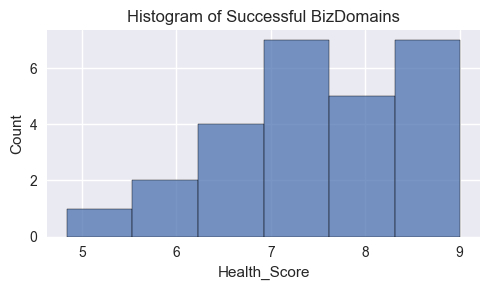

In [25]:
successful  = pd.read_csv(r"SuccesfulCustomers.csv")
successful = successful['BizDomainId'].str.lower()
plt.figure(figsize=(5,3))
plt.style.use('seaborn')
sns.histplot(df_medoid.loc[df_medoid['BizDomainsId'].isin(successful),'Health_Score'])
plt.title('Histogram of Successful BizDomains')
plt.tight_layout()
# plt.savefig('26. LDA Successful Biz.jpg',dpi=200)
plt.show()

### Export

In [26]:
# df_medoid.to_csv('3. medoid k=2 LDA Report.csv')

## Gaussian Naive Bayes

### GridSearch

In [27]:
GNB = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
scorer = {"AUC": "roc_auc", "F1": make_scorer(f1_score) , 
          "Accuracy": 'accuracy'}
grid_NB=GridSearchCV(GNB ,param_grid=params_NB, n_jobs=-1 , cv=10 , verbose = 5,
                         scoring=scorer , refit='F1')
grid_NB.fit(X_train , y_train )
print('best paramters= {}\nbest score= {}'.format(grid_NB.best_params_ , grid_NB.best_score_) )

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
best paramters= {'var_smoothing': 0.002848035868435802}
best score= 0.9199002738066134


### Metrics

In [28]:
df_metric['Value_GNB'] = metric_calculator(y_test , grid_NB.predict(X_test))
df_metric

,most_frequent,stratified,uniform,Value_LogReg,Value_KNN,Value_LDA,Value_GNB
F1 Score,0.000000,0.361949,0.403361,0.934010,0.888889,0.906250,0.903704
accuracy,0.650877,0.517544,0.501754,0.954386,0.924561,0.936842,0.931579
ROC AUC,0.500000,0.488433,0.497271,0.947487,0.910597,0.922361,0.928802
Precision,0.000000,0.336207,0.346570,0.943590,0.914894,0.940541,0.888350
Recall,0.000000,0.391960,0.482412,0.924623,0.864322,0.874372,0.919598


### Health Score for All

In [29]:
GNB = GaussianNB(var_smoothing = 0.002848035868435802)
y_dec_GNB = ((GNB.fit(X, y)).predict_proba(X)[:,1]).reshape(-1,1)
y_dec_GNB = MinMaxScaler(feature_range=(0, 10)).fit_transform(y_dec_GNB)
df_medoid['Health_Score'] = 10 - y_dec_GNB
df_medoid.head()

,no_warning_sign,BizActive?,AddedUsers/BoughtUser,ActiveUsers/AddedUsers,#Activities,ActivitiesWoutDeal/#Activities,AvgDelayTimeActivity,#Activities/#Deals,%NoAcquitance,TransformationSpeed,TransformationRate,%NoReasonFailure,#OngoingDeals/#Total(Correct)Deals,BizIsExpired?,Health_Score,BizDomainsId
0,0.000000,0,0.642724,0.181397,1,0.866667,4,1.068966,0.310345,2,2,3,0.500000,1,0.001777,0006df37-709c-4121-be9e-5210adc6a044
1,0.238875,1,0.398507,0.274307,3,0.662252,3,0.688889,0.917526,2,2,1,0.627451,0,8.793081,002d52c3-6c10-41a5-a4b2-91422a1ab307
2,0.822599,0,1.000000,0.949580,1,0.000000,4,1.444444,0.000000,1,3,1,0.846154,0,1.609074,00428596-e168-49ce-8428-7949cd2215ea
3,0.000000,0,1.000000,0.211382,1,1.000000,3,0.000000,0.602430,2,2,2,0.506440,1,0.003231,0049986f-b17d-44ef-992f-88d478dd21b8
4,0.082940,1,1.000000,0.804726,4,0.773725,2,3.579350,0.182724,2,1,2,0.013858,0,9.858846,004c3ec1-da71-494d-9adb-8a4e660f9257


### Successful Customers Checking

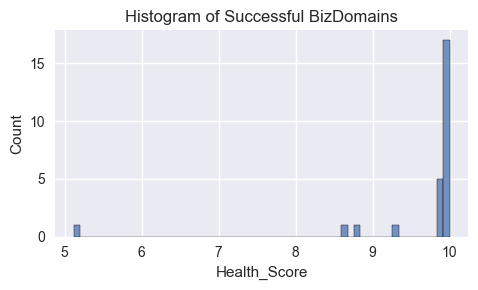

In [30]:
successful  = pd.read_csv(r"SuccesfulCustomers.csv")
successful = successful['BizDomainId'].str.lower()
plt.figure(figsize=(5,3))
plt.style.use('seaborn')
sns.histplot(df_medoid.loc[df_medoid['BizDomainsId'].isin(successful),'Health_Score'])
plt.title('Histogram of Successful BizDomains')
plt.tight_layout()
plt.savefig('27. GNaiveBayes Successful Biz.jpg',dpi=200)
plt.show()

### Export

In [31]:
# df_medoid.to_csv('4. medoid k=2 GNB Report.csv')

## RandomForest

### GridSearch

In [32]:
RFC = RandomForestClassifier(bootstrap=True , oob_score=True)
params_RFC = {'n_estimators':[100,200,300],'criterion':['gini', 'entropy', 'log_loss'],
             'max_depth':np.arange(10,16)}
scorer = {"AUC": "roc_auc", "F1": make_scorer(f1_score) , 
          "Accuracy": 'accuracy'}
grid_RFC=GridSearchCV(RFC ,param_grid=params_RFC, n_jobs=-1 , cv=10 , verbose = 10,
                         scoring=scorer , refit='F1')
grid_RFC.fit(X_train , y_train )
print('best paramters= {}\nbest score= {}'.format(grid_RFC.best_params_ , grid_RFC.best_score_) )

Fitting 10 folds for each of 54 candidates, totalling 540 fits
best paramters= {'criterion': 'gini', 'max_depth': 13, 'n_estimators': 100}
best score= 0.9475637308892597


### Metrics

In [33]:
df_metric['Value_RFC'] = metric_calculator(y_test , grid_RFC.predict(X_test))
df_metric

,most_frequent,stratified,uniform,Value_LogReg,Value_KNN,Value_LDA,Value_GNB,Value_RFC
F1 Score,0.000000,0.361949,0.403361,0.934010,0.888889,0.906250,0.903704,0.957179
accuracy,0.650877,0.517544,0.501754,0.954386,0.924561,0.936842,0.931579,0.970175
ROC AUC,0.500000,0.488433,0.497271,0.947487,0.910597,0.922361,0.928802,0.966605
Precision,0.000000,0.336207,0.346570,0.943590,0.914894,0.940541,0.888350,0.959596
Recall,0.000000,0.391960,0.482412,0.924623,0.864322,0.874372,0.919598,0.954774


### Health Score for All

In [34]:
RFC = RandomForestClassifier(bootstrap=True , oob_score=True,
                             criterion= 'gini', max_depth= 13, n_estimators= 100)
y_dec_RFC = ((RFC.fit(X, y)).predict_proba(X)[:,1]).reshape(-1,1)
y_dec_RFC = MinMaxScaler(feature_range=(0, 10)).fit_transform(y_dec_RFC)
df_medoid['Health_Score'] = 10 - y_dec_RFC
df_medoid.head()

,no_warning_sign,BizActive?,AddedUsers/BoughtUser,ActiveUsers/AddedUsers,#Activities,ActivitiesWoutDeal/#Activities,AvgDelayTimeActivity,#Activities/#Deals,%NoAcquitance,TransformationSpeed,TransformationRate,%NoReasonFailure,#OngoingDeals/#Total(Correct)Deals,BizIsExpired?,Health_Score,BizDomainsId
0,0.000000,0,0.642724,0.181397,1,0.866667,4,1.068966,0.310345,2,2,3,0.500000,1,0.000000,0006df37-709c-4121-be9e-5210adc6a044
1,0.238875,1,0.398507,0.274307,3,0.662252,3,0.688889,0.917526,2,2,1,0.627451,0,9.949057,002d52c3-6c10-41a5-a4b2-91422a1ab307
2,0.822599,0,1.000000,0.949580,1,0.000000,4,1.444444,0.000000,1,3,1,0.846154,0,7.650000,00428596-e168-49ce-8428-7949cd2215ea
3,0.000000,0,1.000000,0.211382,1,1.000000,3,0.000000,0.602430,2,2,2,0.506440,1,0.000000,0049986f-b17d-44ef-992f-88d478dd21b8
4,0.082940,1,1.000000,0.804726,4,0.773725,2,3.579350,0.182724,2,1,2,0.013858,0,10.000000,004c3ec1-da71-494d-9adb-8a4e660f9257


### Successful Customers Checking

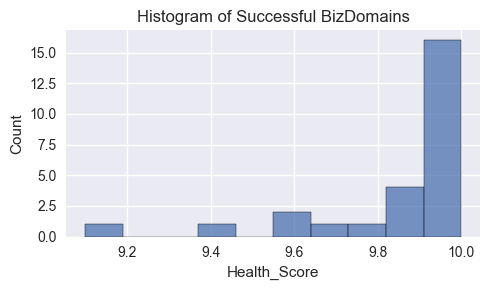

In [35]:
successful  = pd.read_csv(r"SuccesfulCustomers.csv")
successful = successful['BizDomainId'].str.lower()
plt.figure(figsize=(5,3))
plt.style.use('seaborn')
sns.histplot(df_medoid.loc[df_medoid['BizDomainsId'].isin(successful),'Health_Score'])
plt.title('Histogram of Successful BizDomains')
plt.tight_layout()
# plt.savefig('28. LDA Successful Biz.jpg',dpi=200)
plt.show()

### Export

In [36]:
# df_medoid.to_csv('5. medoid k=2 LDA Report.csv')

## AdaBoost (Good)

### GridSearch

In [37]:
ABC = AdaBoostClassifier(base_estimator =LogisticRegression())
params_ABC = {
              'n_estimators':np.arange(10,110,10) , 'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0],
             'algorithm': ['SAMME', 'SAMME.R']},

scorer = {"AUC": "roc_auc", "F1": make_scorer(f1_score) , 
          "Accuracy": 'accuracy'}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_ABC=GridSearchCV(ABC ,param_grid=params_ABC, n_jobs=-1 , cv=cv , verbose = 5,
                         scoring=scorer , refit='F1')
grid_ABC.fit(X_train , y_train )
print('best paramters= {}\nbest score= {}'.format(grid_ABC.best_params_ , grid_ABC.best_score_) )

Fitting 30 folds for each of 100 candidates, totalling 3000 fits
best paramters= {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 70}
best score= 0.944273181526124


### Metrics

In [38]:
df_metric['Value_RFC'] = metric_calculator(y_test , grid_ABC.predict(X_test))
df_metric

,most_frequent,stratified,uniform,Value_LogReg,Value_KNN,Value_LDA,Value_GNB,Value_RFC
F1 Score,0.000000,0.361949,0.403361,0.934010,0.888889,0.906250,0.903704,0.934010
accuracy,0.650877,0.517544,0.501754,0.954386,0.924561,0.936842,0.931579,0.954386
ROC AUC,0.500000,0.488433,0.497271,0.947487,0.910597,0.922361,0.928802,0.947487
Precision,0.000000,0.336207,0.346570,0.943590,0.914894,0.940541,0.888350,0.943590
Recall,0.000000,0.391960,0.482412,0.924623,0.864322,0.874372,0.919598,0.924623


### Health Score for All

In [39]:
ABC = AdaBoostClassifier(base_estimator =LogisticRegression() , algorithm='SAMME.R',
                        learning_rate=1 , n_estimators=70)
y_dec_ABC = ((ABC.fit(X, y)).decision_function(X)).reshape(-1,1)
y_dec_ABC = MinMaxScaler(feature_range=(0, 10)).fit_transform(y_dec_ABC)
df_medoid['Health_Score'] = 10 - y_dec_ABC
df_medoid.head()

,no_warning_sign,BizActive?,AddedUsers/BoughtUser,ActiveUsers/AddedUsers,#Activities,ActivitiesWoutDeal/#Activities,AvgDelayTimeActivity,#Activities/#Deals,%NoAcquitance,TransformationSpeed,TransformationRate,%NoReasonFailure,#OngoingDeals/#Total(Correct)Deals,BizIsExpired?,Health_Score,BizDomainsId
0,0.000000,0,0.642724,0.181397,1,0.866667,4,1.068966,0.310345,2,2,3,0.500000,1,0.000000,0006df37-709c-4121-be9e-5210adc6a044
1,0.238875,1,0.398507,0.274307,3,0.662252,3,0.688889,0.917526,2,2,1,0.627451,0,9.838496,002d52c3-6c10-41a5-a4b2-91422a1ab307
2,0.822599,0,1.000000,0.949580,1,0.000000,4,1.444444,0.000000,1,3,1,0.846154,0,3.837836,00428596-e168-49ce-8428-7949cd2215ea
3,0.000000,0,1.000000,0.211382,1,1.000000,3,0.000000,0.602430,2,2,2,0.506440,1,0.000000,0049986f-b17d-44ef-992f-88d478dd21b8
4,0.082940,1,1.000000,0.804726,4,0.773725,2,3.579350,0.182724,2,1,2,0.013858,0,7.748246,004c3ec1-da71-494d-9adb-8a4e660f9257


### Successful Customers Checking

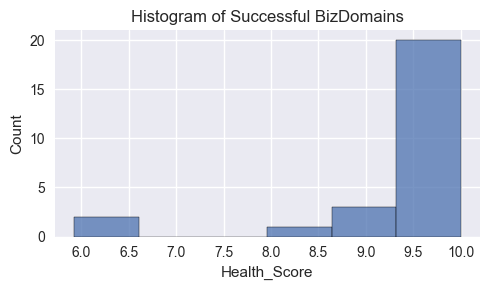

In [40]:
successful  = pd.read_csv(r"SuccesfulCustomers.csv")
successful = successful['BizDomainId'].str.lower()
plt.figure(figsize=(5,3))
plt.style.use('seaborn')
sns.histplot(df_medoid.loc[df_medoid['BizDomainsId'].isin(successful),'Health_Score'])
plt.title('Histogram of Successful BizDomains')
plt.tight_layout()
# plt.savefig('29. Ada Successful Biz.jpg',dpi=200)
plt.show()

### Export

In [41]:
# df_medoid.to_csv('6. medoid k=2 ADA Report.csv')

## SVC

### GridSearch

In [42]:
svc = SVC()
params_svc = {
              'C':[0.1,1,10,100,250] , 'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
             'gamma': ['scale', 'auto'] , 'shrinking':[True , False]},

scorer = {"AUC": "roc_auc", "F1": make_scorer(f1_score) , 
          "Accuracy": 'accuracy'}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_svc=GridSearchCV(svc ,param_grid=params_svc, n_jobs=-1 , cv=cv , verbose = 5,
                         scoring=scorer , refit='F1')
grid_svc.fit(X_train , y_train )
print('best paramters= {}\nbest score= {}'.format(grid_svc.best_params_ , grid_svc.best_score_) )

Fitting 30 folds for each of 80 candidates, totalling 2400 fits
best paramters= {'C': 100, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}
best score= 0.948603566044419


### Metrics

In [43]:
df_metric['Value_SVC'] = metric_calculator(y_test , grid_svc.predict(X_test))
df_metric

,most_frequent,stratified,uniform,Value_LogReg,Value_KNN,Value_LDA,Value_GNB,Value_RFC,Value_SVC
F1 Score,0.000000,0.361949,0.403361,0.934010,0.888889,0.906250,0.903704,0.934010,0.965174
accuracy,0.650877,0.517544,0.501754,0.954386,0.924561,0.936842,0.931579,0.954386,0.975439
ROC AUC,0.500000,0.488433,0.497271,0.947487,0.910597,0.922361,0.928802,0.947487,0.975308
Precision,0.000000,0.336207,0.346570,0.943590,0.914894,0.940541,0.888350,0.943590,0.955665
Recall,0.000000,0.391960,0.482412,0.924623,0.864322,0.874372,0.919598,0.924623,0.974874


### Health Score for All

In [44]:
svc = SVC(C=100 , gamma='scale' , kernel='rbf' , shrinking=True)
y_dec_SVC = ((svc.fit(X, y)).decision_function(X)).reshape(-1,1)
y_dec_SVC = MinMaxScaler(feature_range=(0, 10)).fit_transform(y_dec_SVC)
df_medoid['Health_Score'] = 10 - y_dec_SVC
df_medoid.head()

,no_warning_sign,BizActive?,AddedUsers/BoughtUser,ActiveUsers/AddedUsers,#Activities,ActivitiesWoutDeal/#Activities,AvgDelayTimeActivity,#Activities/#Deals,%NoAcquitance,TransformationSpeed,TransformationRate,%NoReasonFailure,#OngoingDeals/#Total(Correct)Deals,BizIsExpired?,Health_Score,BizDomainsId
0,0.000000,0,0.642724,0.181397,1,0.866667,4,1.068966,0.310345,2,2,3,0.500000,1,1.341359,0006df37-709c-4121-be9e-5210adc6a044
1,0.238875,1,0.398507,0.274307,3,0.662252,3,0.688889,0.917526,2,2,1,0.627451,0,7.326827,002d52c3-6c10-41a5-a4b2-91422a1ab307
2,0.822599,0,1.000000,0.949580,1,0.000000,4,1.444444,0.000000,1,3,1,0.846154,0,6.392812,00428596-e168-49ce-8428-7949cd2215ea
3,0.000000,0,1.000000,0.211382,1,1.000000,3,0.000000,0.602430,2,2,2,0.506440,1,0.838609,0049986f-b17d-44ef-992f-88d478dd21b8
4,0.082940,1,1.000000,0.804726,4,0.773725,2,3.579350,0.182724,2,1,2,0.013858,0,6.702066,004c3ec1-da71-494d-9adb-8a4e660f9257


### Successful Customers Checking

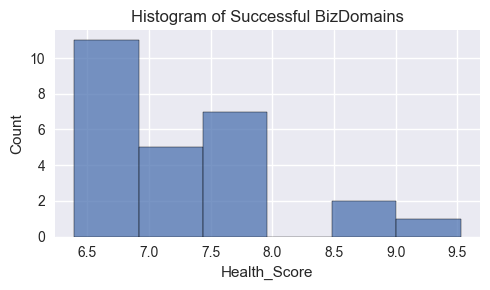

In [45]:
successful  = pd.read_csv(r"SuccesfulCustomers.csv")
successful = successful['BizDomainId'].str.lower()
plt.figure(figsize=(5,3))
plt.style.use('seaborn')
sns.histplot(df_medoid.loc[df_medoid['BizDomainsId'].isin(successful),'Health_Score'])
plt.title('Histogram of Successful BizDomains')
plt.tight_layout()
# plt.savefig('27. SVC Successful Biz.jpg',dpi=200)
plt.show()

### Export

In [46]:
# df_medoid.to_csv('7.medoid k=2 SVC Report.csv')

## NuSVC (Good)

### GridSearch

In [47]:
nsvc = NuSVC()
params_nsvc = {'nu':np.arange(0.1,1.1 , 0.1), 'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
             'gamma': ['scale', 'auto'] , 'shrinking':[True , False]},

scorer = {"AUC": "roc_auc", "F1": make_scorer(f1_score) , 
          "Accuracy": 'accuracy'}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_nsvc=GridSearchCV(nsvc ,param_grid=params_nsvc, n_jobs=-1 , cv=cv , verbose = 5,
                         scoring=scorer , refit='F1')
grid_nsvc.fit(X_train , y_train )
print('best paramters= {}\nbest score= {}'.format(grid_nsvc.best_params_ , grid_nsvc.best_score_) )

Fitting 30 folds for each of 160 candidates, totalling 4800 fits
best paramters= {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.1, 'shrinking': True}
best score= 0.9451369774022467


### Metrics

In [48]:
df_metric['Value_NSVC'] = metric_calculator(y_test , grid_nsvc.predict(X_test))
df_metric

,most_frequent,stratified,uniform,Value_LogReg,Value_KNN,Value_LDA,Value_GNB,Value_RFC,Value_SVC,Value_NSVC
F1 Score,0.000000,0.361949,0.403361,0.934010,0.888889,0.906250,0.903704,0.934010,0.965174,0.959799
accuracy,0.650877,0.517544,0.501754,0.954386,0.924561,0.936842,0.931579,0.954386,0.975439,0.971930
ROC AUC,0.500000,0.488433,0.497271,0.947487,0.910597,0.922361,0.928802,0.947487,0.975308,0.969118
Precision,0.000000,0.336207,0.346570,0.943590,0.914894,0.940541,0.888350,0.943590,0.955665,0.959799
Recall,0.000000,0.391960,0.482412,0.924623,0.864322,0.874372,0.919598,0.924623,0.974874,0.959799


### Health Score for All

In [49]:
nsvc = NuSVC(gamma='scale' , kernel='rbf' , shrinking=True,nu=0.1)
y_dec_NSVC = ((nsvc.fit(X, y)).decision_function(X)).reshape(-1,1)
y_dec_NSVC = MinMaxScaler(feature_range=(0, 10)).fit_transform(y_dec_NSVC)
df_medoid['Health_Score'] = 10 - y_dec_NSVC
df_medoid.head()

,no_warning_sign,BizActive?,AddedUsers/BoughtUser,ActiveUsers/AddedUsers,#Activities,ActivitiesWoutDeal/#Activities,AvgDelayTimeActivity,#Activities/#Deals,%NoAcquitance,TransformationSpeed,TransformationRate,%NoReasonFailure,#OngoingDeals/#Total(Correct)Deals,BizIsExpired?,Health_Score,BizDomainsId
0,0.000000,0,0.642724,0.181397,1,0.866667,4,1.068966,0.310345,2,2,3,0.500000,1,1.122190,0006df37-709c-4121-be9e-5210adc6a044
1,0.238875,1,0.398507,0.274307,3,0.662252,3,0.688889,0.917526,2,2,1,0.627451,0,7.934546,002d52c3-6c10-41a5-a4b2-91422a1ab307
2,0.822599,0,1.000000,0.949580,1,0.000000,4,1.444444,0.000000,1,3,1,0.846154,0,5.445678,00428596-e168-49ce-8428-7949cd2215ea
3,0.000000,0,1.000000,0.211382,1,1.000000,3,0.000000,0.602430,2,2,2,0.506440,1,0.717712,0049986f-b17d-44ef-992f-88d478dd21b8
4,0.082940,1,1.000000,0.804726,4,0.773725,2,3.579350,0.182724,2,1,2,0.013858,0,7.646725,004c3ec1-da71-494d-9adb-8a4e660f9257


### Successful Customers Checking

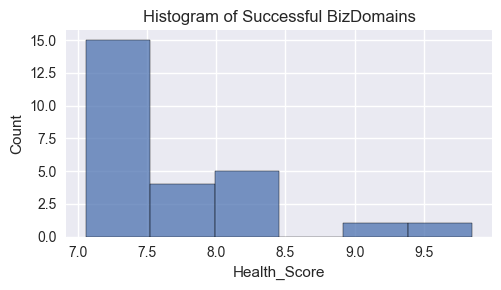

In [50]:
successful  = pd.read_csv(r"SuccesfulCustomers.csv")
successful = successful['BizDomainId'].str.lower()
plt.figure(figsize=(5,3))
plt.style.use('seaborn')
sns.histplot(df_medoid.loc[df_medoid['BizDomainsId'].isin(successful),'Health_Score'])
plt.title('Histogram of Successful BizDomains')
plt.tight_layout()
# plt.savefig('28. NuSVC Successful Biz.jpg',dpi=200)
plt.show()

### Export

In [51]:
# df_medoid.to_csv('8. medoid k=2 NuSVC Report.csv')

## LinearSVC

### GridSearch

In [52]:
lsvc = LinearSVC(dual=False)
params_lsvc = {'penalty':['l1','l2'], 'loss':['hinge', 'squared_hinge'],
             'C': [0.1,1,10,100,250] }

scorer = {"AUC": "roc_auc", "F1": make_scorer(f1_score) , 
          "Accuracy": 'accuracy'}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_lsvc=GridSearchCV(lsvc ,param_grid=params_lsvc, n_jobs=-1 , cv=cv , verbose = 5,
                         scoring=scorer , refit='F1')
grid_lsvc.fit(X_train , y_train )
print('best paramters= {}\nbest score= {}'.format(grid_lsvc.best_params_ , grid_lsvc.best_score_) )

Fitting 30 folds for each of 20 candidates, totalling 600 fits
best paramters= {'C': 1, 'loss': 'squared_hinge', 'penalty': 'l1'}
best score= 0.9447566348096078


### Metrics

In [53]:
df_metric['Value_LSVC'] = metric_calculator(y_test , grid_lsvc.predict(X_test))
df_metric

,most_frequent,stratified,uniform,Value_LogReg,Value_KNN,Value_LDA,Value_GNB,Value_RFC,Value_SVC,Value_NSVC,Value_LSVC
F1 Score,0.000000,0.361949,0.403361,0.934010,0.888889,0.906250,0.903704,0.934010,0.965174,0.959799,0.946835
accuracy,0.650877,0.517544,0.501754,0.954386,0.924561,0.936842,0.931579,0.954386,0.975439,0.971930,0.963158
ROC AUC,0.500000,0.488433,0.497271,0.947487,0.910597,0.922361,0.928802,0.947487,0.975308,0.969118,0.957720
Precision,0.000000,0.336207,0.346570,0.943590,0.914894,0.940541,0.888350,0.943590,0.955665,0.959799,0.954082
Recall,0.000000,0.391960,0.482412,0.924623,0.864322,0.874372,0.919598,0.924623,0.974874,0.959799,0.939698


### Health Score for All

In [54]:
lsvc = LinearSVC(dual=False ,C= 1, loss= 'squared_hinge', penalty= 'l1')
y_dec_LSVC = ((lsvc.fit(X, y)).decision_function(X)).reshape(-1,1)
y_dec_LSVC = MinMaxScaler(feature_range=(0, 10)).fit_transform(y_dec_LSVC)
df_medoid['Health_Score'] = 10 - y_dec_LSVC
df_medoid.head()

,no_warning_sign,BizActive?,AddedUsers/BoughtUser,ActiveUsers/AddedUsers,#Activities,ActivitiesWoutDeal/#Activities,AvgDelayTimeActivity,#Activities/#Deals,%NoAcquitance,TransformationSpeed,TransformationRate,%NoReasonFailure,#OngoingDeals/#Total(Correct)Deals,BizIsExpired?,Health_Score,BizDomainsId
0,0.000000,0,0.642724,0.181397,1,0.866667,4,1.068966,0.310345,2,2,3,0.500000,1,1.045719,0006df37-709c-4121-be9e-5210adc6a044
1,0.238875,1,0.398507,0.274307,3,0.662252,3,0.688889,0.917526,2,2,1,0.627451,0,6.491782,002d52c3-6c10-41a5-a4b2-91422a1ab307
2,0.822599,0,1.000000,0.949580,1,0.000000,4,1.444444,0.000000,1,3,1,0.846154,0,5.058761,00428596-e168-49ce-8428-7949cd2215ea
3,0.000000,0,1.000000,0.211382,1,1.000000,3,0.000000,0.602430,2,2,2,0.506440,1,1.314663,0049986f-b17d-44ef-992f-88d478dd21b8
4,0.082940,1,1.000000,0.804726,4,0.773725,2,3.579350,0.182724,2,1,2,0.013858,0,6.196868,004c3ec1-da71-494d-9adb-8a4e660f9257


### Successful Customers Checking

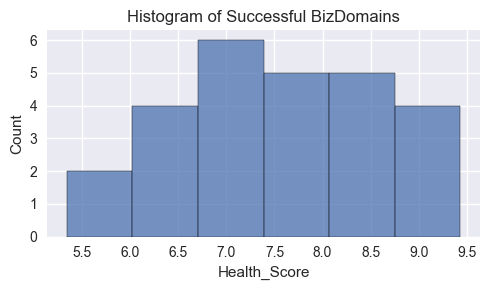

In [55]:
successful  = pd.read_csv(r"SuccesfulCustomers.csv")
successful = successful['BizDomainId'].str.lower()
plt.figure(figsize=(5,3))
plt.style.use('seaborn')
sns.histplot(df_medoid.loc[df_medoid['BizDomainsId'].isin(successful),'Health_Score'])
plt.title('Histogram of Successful BizDomains')
plt.tight_layout()
# plt.savefig('29. LinearSVC Successful Biz.jpg',dpi=200)
plt.show()

### Export

In [56]:
# df_medoid.to_csv('9. medoid k=2 LinearSVC Report.csv')

## GradientBoostingClassifier (Best)

### GridSearch

In [57]:
gbc = GradientBoostingClassifier()
params_gbc = {'loss':['log_loss', 'exponential'], 'learning_rate':[0.01,0.05,0.1,0.15,0.2],
             'n_estimators':[300,400],'subsample': [0.8,0.85,0.9,0.95,1],
               'max_features':['sqrt', 'log2']}

scorer = {"AUC": "roc_auc", "F1": make_scorer(f1_score) , 
          "Accuracy": 'accuracy'}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_gbc=GridSearchCV(gbc ,param_grid=params_gbc, n_jobs=-1 , cv=cv , verbose = 5,
                         scoring=scorer , refit='F1')
grid_gbc.fit(X_train , y_train )
print('best paramters= {}\nbest score= {}'.format(grid_gbc.best_params_ , grid_gbc.best_score_) )

Fitting 30 folds for each of 300 candidates, totalling 9000 fits
best paramters= {'learning_rate': 0.1, 'loss': 'log_loss', 'max_features': 'log2', 'n_estimators': 300, 'subsample': 0.8}
best score= 0.9595635014782051


### Metrics

In [58]:
df_metric['Value_GBR'] = metric_calculator(y_test , grid_gbc.predict(X_test))
df_metric

,most_frequent,stratified,uniform,Value_LogReg,Value_KNN,Value_LDA,Value_GNB,Value_RFC,Value_SVC,Value_NSVC,Value_LSVC,Value_GBR
F1 Score,0.000000,0.361949,0.403361,0.934010,0.888889,0.906250,0.903704,0.934010,0.965174,0.959799,0.946835,0.962025
accuracy,0.650877,0.517544,0.501754,0.954386,0.924561,0.936842,0.931579,0.954386,0.975439,0.971930,0.963158,0.973684
ROC AUC,0.500000,0.488433,0.497271,0.947487,0.910597,0.922361,0.928802,0.947487,0.975308,0.969118,0.957720,0.969301
Precision,0.000000,0.336207,0.346570,0.943590,0.914894,0.940541,0.888350,0.943590,0.955665,0.959799,0.954082,0.969388
Recall,0.000000,0.391960,0.482412,0.924623,0.864322,0.874372,0.919598,0.924623,0.974874,0.959799,0.939698,0.954774


### Health Score for All

In [59]:
gbr = GradientBoostingClassifier(learning_rate= 0.1, loss= 'log_loss',
                                 max_features='log2', n_estimators= 300, subsample= 0.8)
y_dec_gbr = ((gbr.fit(X, y)).decision_function(X)).reshape(-1,1)
y_dec_gbr = MinMaxScaler(feature_range=(0, 10)).fit_transform(y_dec_gbr)
df_medoid['Health_Score'] = 10 - y_dec_gbr
df_medoid.head()

,no_warning_sign,BizActive?,AddedUsers/BoughtUser,ActiveUsers/AddedUsers,#Activities,ActivitiesWoutDeal/#Activities,AvgDelayTimeActivity,#Activities/#Deals,%NoAcquitance,TransformationSpeed,TransformationRate,%NoReasonFailure,#OngoingDeals/#Total(Correct)Deals,BizIsExpired?,Health_Score,BizDomainsId
0,0.000000,0,0.642724,0.181397,1,0.866667,4,1.068966,0.310345,2,2,3,0.500000,1,2.337788,0006df37-709c-4121-be9e-5210adc6a044
1,0.238875,1,0.398507,0.274307,3,0.662252,3,0.688889,0.917526,2,2,1,0.627451,0,8.286262,002d52c3-6c10-41a5-a4b2-91422a1ab307
2,0.822599,0,1.000000,0.949580,1,0.000000,4,1.444444,0.000000,1,3,1,0.846154,0,6.926666,00428596-e168-49ce-8428-7949cd2215ea
3,0.000000,0,1.000000,0.211382,1,1.000000,3,0.000000,0.602430,2,2,2,0.506440,1,2.041020,0049986f-b17d-44ef-992f-88d478dd21b8
4,0.082940,1,1.000000,0.804726,4,0.773725,2,3.579350,0.182724,2,1,2,0.013858,0,7.495541,004c3ec1-da71-494d-9adb-8a4e660f9257


### Feature Importance

In [60]:
imp = gbr.feature_importances_
pd.DataFrame({'Column Name':df_medoid.columns[:len(imp)] , 'Importance':imp})

,Column Name,Importance
0,no_warning_sign,0.091026
1,BizActive?,0.443928
2,AddedUsers/BoughtUser,0.006103
3,ActiveUsers/AddedUsers,0.028487
4,#Activities,0.158347
5,ActivitiesWoutDeal/#Activities,0.049150
6,AvgDelayTimeActivity,0.003220
7,#Activities/#Deals,0.057089
8,%NoAcquitance,0.007668
9,TransformationSpeed,0.000379


### Successful Customers Checking

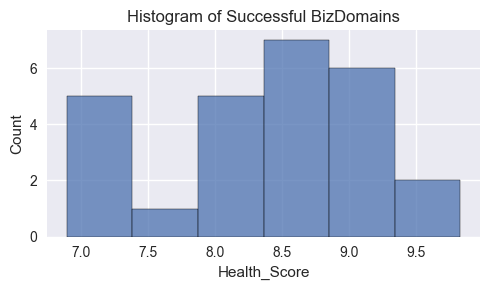

In [62]:
successful  = pd.read_csv(r"SuccesfulCustomers.csv")
successful = successful['BizDomainId'].str.lower()
plt.figure(figsize=(5,3))
plt.style.use('seaborn')
sns.histplot(df_medoid.loc[df_medoid['BizDomainsId'].isin(successful),'Health_Score'])
plt.title('Histogram of Successful BizDomains')
plt.tight_layout()
# plt.savefig('30. GBC Successful Biz.jpg',dpi=200)
plt.show()

### Export

In [63]:
df_medoid.to_csv('10. medoid k=2 GBC Report.csv')